# Feature evolution

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('..'))
from utils import setup_spreadr

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr' + os.path.split(os.path.abspath(os.path.curdir))[1][9:]
setup_spreadr(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_2


Imports for the analysis

In [14]:
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
import spacy
from statsmodels.stats.proportion import multinomial_proportions_confint

from gists.models import Sentence, Tree, GistsConfiguration

from features import Features
from utils import memoized

config = GistsConfiguration.get_solo()

Equip models with useful tools

In [4]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

Create our spaCy instance (only run this once! It's a memory hog)

In [5]:
nlp = spacy.load('en')

## 2 Appearance and disappearance for categorical variables

Here are the possible approaches to compare to sentences (lists of tokens, lemmas, POSs, whatever).

**Bag of words**

Look at the two lists as unordered bags, and look at one minus the other.

Good:
* Gives you bags of appeared/disappeared items (you weigh each item by the number of times it is present in a bag)
* You know that each appeared/disappeared item in your bags correspond to items that have effectively appeared or disappeared

Bad:
* You can't place the appearances/disappearances in the parent/child sentences (unless the item is the only one of its kind in the parent or child sentences)
* Those bags don't necessarily cover *all* appearances/disappearances: a word could have been replaced by another of same category (you don't see that), or could have been moved in the sentence, or both

**Minimal path from one to the other**

Compute the Levenshtein shortest paths (with exchange) transforming one list into the other, and count replacement/insertion/deletion on the words involved in the shortest paths (weighing accordingly if there are several paths).

Good:
* Gives you bags of appeared/disappeared items
* Lets you place the appearanecs/disappearances in the parent/child sentences

Bad:
* It doesn't necessarily represent the psychological path taken (if that notion makes sense at all). In a way, it's half-baked: you start modelling the transformation process, but without any syntax trees or psychological considerations
* On tokens, you will count a change in inflection as a replacement (but you could also ignore those)
* On lemmas, you don't have the problem from the previous point, but you lose precision in the transformation path
* Moving a part of the sentence (a syntax tree exchange) will count as many exchanges (or deletion+insertion) as there are words to move

**Conclusion**

Go with bags of words: it's simpler, and choosing the second option is half-baked.

---

* for each transformation
  * count the final app/disapp of tokens or lemmas
  * for each property
    * store each value with its app/disapp counts (separately, as they could cancel each other otherwise, since we base counts on the words and get categories afterwards) and its sentence counts

For categorical properties: plot bars summing the app/disapp counts per category (scaled to sentence unit), compared to counts of all sentences (scaled to sentence unit).

For continuous properties:
* bin them per global distribution quartiles, and plot sums (scaled to sentence unit) per bin
* bin them per sentence quartiles, and plot sums (scaled to sentence unit, and distributing properly when there wasn't enough bins) per bin, compared to (or divided by) counts of all sentences

In [6]:
@memoized
def depth_under_token(tok):
    children_depths = [depth_under_token(child)
                       for child in tok.children]
    return 0 if len(children_depths) == 0 else 1 + np.max(children_depths)

def dep_depth(doc):
    return depth_under_token([tok for tok in doc if tok.head == tok][0])

In [102]:
def doc_properties(doc, getter):
    # getter : (doc, word, i) -> word property
    return [getter(doc, word, i)
            for i, word in enumerate(doc)
            if (not word.is_punct
                and not word.is_space)]

def differences(parent_doc, child_doc, getter):
    # getter : (doc, word, i) -> word property
    parent_counts = Counter(doc_properties(parent_doc, getter))
    diff_counts = Counter(doc_properties(child_doc, getter))
    diff_counts.subtract(parent_counts)
    return diff_counts

#def qposition(values, value):
#    if np.isnan(value):
#        return np.nan, np.nan
#    finite_values = values[np.isfinite(values)]
#    svalues = np.array(sorted(finite_values))
#    length = len(svalues)
#    ours = np.where(svalues == value)[0]
#    return ours[0] / length, (ours[-1] + 1) / length

def rows(parent, child, prop_name, getter):
    # getter : (doc, word, i) -> word property
    
    parent_doc = nlp(parent.text)
    parent_props = doc_properties(parent_doc, getter)
    parent_counts = Counter(parent_props)
        
    child_doc = nlp(child.text)
    child_props = doc_properties(child_doc, getter)
    diff_counts = Counter(child_props)
    diff_counts.subtract(parent_counts)
    
    for key in set(parent_props + child_props):
        if not isinstance(key, str) and np.isnan(key):
            continue

        # Get the key's quantile position.
        #start_quantile, stop_quantile = qposition(XXXX, key)
        
        yield {
            'tree id': parent.tree.id,
            'parent id': parent.id,
            'child id': child.id,
            'branch id': child.head.id,
            
            'depth': parent.depth,
            'is root': parent.depth == 0,
            'oc rate': parent.ordered_content_distance(child),
            'oc transmitted': int(parent.ordered_content_distance(child) == 0),
            'content length': len(parent.content_words),
            'token length': len(parent_doc),
            'root memorable': int(parent.tree.id % 2 == 0),
            
            'property': prop_name,
            'value': key,
            'parent count': parent_counts[key],
            'diff': diff_counts[key],
        }

In [162]:
feature_computer = Features()
properties = dict(
    [('POS', lambda doc, word, i: word.pos),
     ('dep', lambda doc, word, i: word.dep),
     ('depth under', lambda doc, word, i: depth_under_token(word))]
    + [(fname,
        # Why the nested lambdas? See the end of answer http://stackoverflow.com/a/34021333
        (lambda fname_:
         (lambda doc, word, i: feature_computer.feature(fname_, doc, i))
        )(fname)
       )
       for fname in Features.__features__.keys()])

data = []
for tree in Tree.objects.experiment:
    for parent in tree.sentences.kept:

        parent_depth = parent.depth
        if parent_depth >= config.target_branch_depth:
            # Ignore reformulations with
            # out-of-shape children
            continue
        
        children = parent.children.kept
        if len(children) == 0:
            # Ignore leaves, we already saw them
            # with their parent
            continue
        
        for child in children:
            if child.depth > config.target_branch_depth:
                # Again, ignore out-of-shape sentences
                # (though this should be redundant with the above)
                continue
            
            for prop_name, getter in properties.items():
                for row in rows(parent, child, prop_name, getter):
                    data.append(row)

words = pd.DataFrame(data)

In [163]:
# Weight is 1, at first
words['weight_parent'] = 1
words['weight_+'] = 1
words['weight_-'] = 1

# Divided by the number of words counted in the parent
print('Computing shared parent (all) weights')
words['weight_parent'] = words\
    .groupby(['parent id', 'property'])['weight_parent']\
    .transform(lambda x: x / words.loc[x.index]['parent count'].sum())

# Or by the number of positive or negative diffs
print('Computing shared parent (+) weights')
words['weight_+'] = words\
    .groupby(['parent id', 'property'])['weight_+']\
    .transform(lambda x: x / ((words.loc[x.index]['diff'] > 0)
                              * abs(words.loc[x.index]['diff'])).sum())
print('Computing shared parent (-) weights')
words['weight_-'] = words\
    .groupby(['parent id', 'property'])['weight_-']\
    .transform(lambda x: x / ((words.loc[x.index]['diff'] < 0)
                              * abs(words.loc[x.index]['diff'])).sum())

Computing shared parent (all) weights
Computing shared parent (+) weights
Computing shared parent (-) weights


In [222]:
def categorical_counts_proportions_suscepts(df, prop_name, rename_index=None):
    # Compute counts.
    parent_counts = df[df.property == prop_name]\
        .groupby('value')['parent count']\
        .aggregate(lambda x: (x * df.loc[x.index, 'weight_parent']).sum())\
        .rename_axis(prop_name)
    appeared_counts = df[(df.property == prop_name) & (df['diff'] > 0)]\
        .groupby('value')['diff']\
        .aggregate(lambda x: (x * words.loc[x.index, 'weight_+']).sum())\
        .rename_axis(prop_name)
    disappeared_counts = df[(df.property == prop_name) & (df['diff'] < 0)]\
        .groupby('value')['diff']\
        .aggregate(lambda x: (abs(x) * words.loc[x.index, 'weight_-']).sum())\
        .rename_axis(prop_name)
    # Massage into DataFrames.
    counts = pd.DataFrame(
        {'parent': parent_counts,
         'appeared': appeared_counts,
         'disappeared': disappeared_counts}
    )
    if rename_index is not None:
        counts = counts.rename(index=rename_index)
    counts = counts[['parent', 'appeared', 'disappeared']]
    proportions = counts / counts.sum()
    suscepts = pd.DataFrame(
       {'appeared': proportions.appeared / proportions.parent,
        'disappeared': proportions.disappeared / proportions.parent})
    
    return counts, proportions, suscepts

In [258]:
def plot_susties(counts, proportions, suscepts, axes=None, ci=True,
                 count_plot_kws={}, suscept_plot_kws={}, ci_kws={}):
    if axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    prop_name = counts.index.name
    ci_lw = ci_kws.pop('lw', 4)
    ci_color = ci_kws.pop('color', 'grey')

    # Raw appeared/disappeared/parent values.
    proportions\
        .rename(columns={'parent': '$s_{{{}}}^0$'.format(prop_name),
                         'appeared': '$s_{{{}}}^+$'.format(prop_name),
                         'disappeared': '$s_{{{}}}^-$'.format(prop_name)})\
        .plot(ax=axes[0], kind='bar', width=.75, **count_plot_kws)
    # With their CIs.
    if ci:
        cis_appeared = multinomial_proportions_confint(
            counts.appeared.round(), method='goodman')
        cis_disappeared = multinomial_proportions_confint(
            counts.disappeared.round(), method='goodman')
        for i in range(len(counts)):
            axes[0].plot([i, i], cis_appeared[i],
                         lw=ci_lw, color=ci_color,
                         label='95% CI' if i == 0 else None)
            axes[0].plot([i+.25, i+.25], cis_disappeared[i],
                         lw=ci_lw, color=ci_color)
    # Set chrome.
    axes[0].legend()
    axes[0].set_ylabel('Fraction of total counted')
    
    # Substitutability values.
    suscepts\
        .rename(columns={'appeared': r'$\sigma_{{{}}}^+$'.format(prop_name),
                         'disappeared': r'$\sigma_{{{}}}^-$'.format(prop_name)})\
        .apply(np.log10)\
        .plot(ax=axes[1], kind='bar', legend=True,
              color=sb.color_palette()[1:3], **suscept_plot_kws)
    axes[1].set_ylabel('Susceptibility')
    # With their CIs.
    if ci:
        for i in range(len(counts)):
            axes[1].plot([i-.125, i-.125],
                         np.log10(cis_appeared[i] / proportions.parent.iloc[i]),
                         lw=ci_lw, color=ci_color,
                         label='95% CI' if i == 0 else None,
                         **ci_kws)
            axes[1].plot([i+.125, i+.125],
                         np.log10(cis_disappeared[i] / proportions.parent.iloc[i]),
                         lw=ci_lw, color=ci_color, **ci_kws)
    # Set chrome
    axes[1].plot([-1, len(counts)], [0, 0], '--',
                 color=sb.desaturate(sb.color_palette()[0], 0.2),
                 label=r'$\mathcal{H}_0$')
    axes[1].legend(loc='best')
    axes[1].set_yticklabels(['$10^{{{:.2}}}$'.format(tick)
                             for tick in axes[1].get_yticks()])
    
    return axes

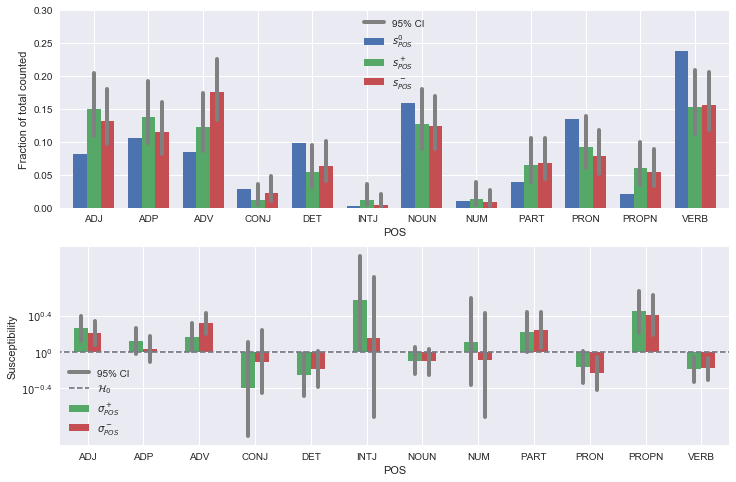

In [246]:
POS_counts, POS_proportions, POS_suscepts = categorical_counts_proportions_suscepts(
    words, 'POS', rename_index=lambda n: nlp.vocab.strings[int(n)])
POS_counts = POS_counts[POS_counts.index != 'X']
POS_proportions = POS_proportions[POS_proportions.index != 'X']
POS_suscepts = POS_suscepts[POS_suscepts.index != 'X']

axes = plot_susties(POS_counts, POS_proportions, POS_suscepts,
                    count_plot_kws={'rot': 0}, suscept_plot_kws={'rot': 0})
axes[0].set_ylim((0, .3))
axes[1].set_yticks([-.4, 0, .4])
axes[1].set_yticklabels(['$10^{-0.4}$', '$10^{0}$', '$10^{0.4}$'])

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10




array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa608504cc0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fa6084c8d68>], dtype=object)

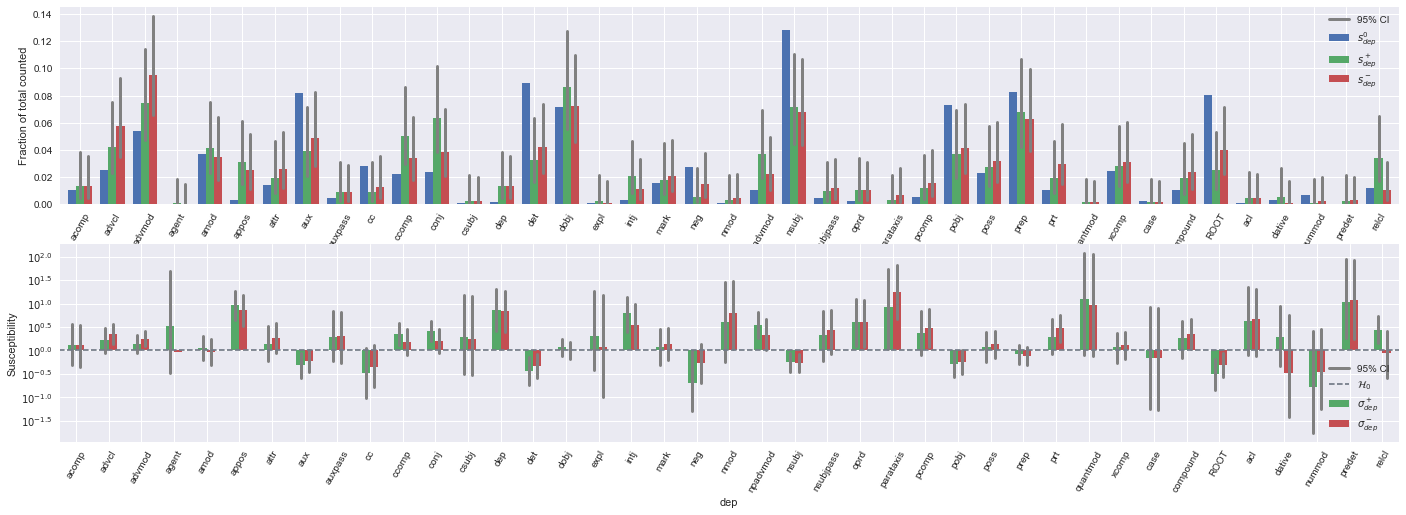

In [260]:
dep_counts, dep_proportions, dep_suscepts = categorical_counts_proportions_suscepts(
    words, 'dep', rename_index=lambda n: nlp.vocab.strings[int(n)])

fig, axes = plt.subplots(2, 1, figsize=(24, 8))
plot_susties(dep_counts, dep_proportions, dep_suscepts,
             axes=axes,
             count_plot_kws={'rot': 60}, suscept_plot_kws={'rot': 60},
             ci_kws={'lw': 3})

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log10


/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10




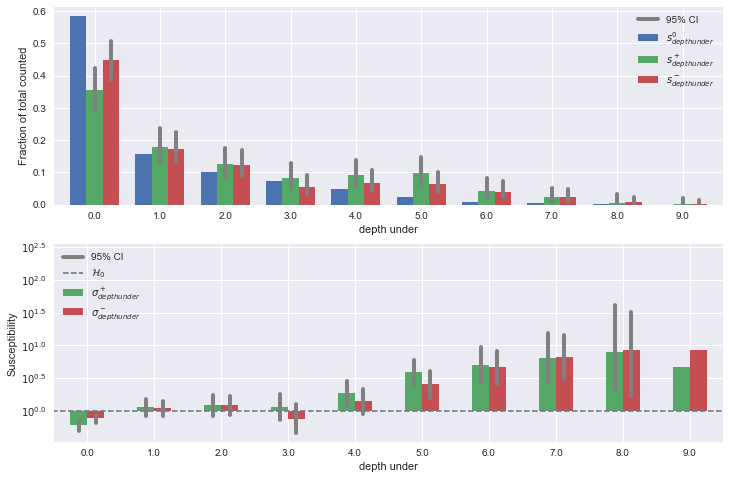

In [259]:
depth_under_counts, depth_under_proportions, depth_under_suscepts = \
    categorical_counts_proportions_suscepts(words, 'depth under')

axes = plot_susties(depth_under_counts, depth_under_proportions, depth_under_suscepts,
                    count_plot_kws={'rot': 0}, suscept_plot_kws={'rot': 0})

In [272]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].property
    quantiles = kwargs.get('quantiles', False)
    value = data.value
    binning = kwargs.get('binning', 5)
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(binning, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts.
    heights_appeared = np.zeros(bin_count)
    heights_disappeared = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        idx_appeared = (value_bins == i) & (data['diff'] > 0)
        heights_appeared[i] = (data[idx_appeared]['diff']
                               * data[idx_appeared]['weight_+']).sum()
        idx_disappeared = (value_bins == i) & (data['diff'] < 0)
        heights_disappeared[i] = - (data[idx_disappeared]['diff']
                                    * data[idx_disappeared]['weight_-']).sum()
        h0s[i] = (data[value_bins == i]['parent count']
                  * data[value_bins == i]['weight_parent']).sum()
    total_appeared = sum(heights_appeared)
    total_disappeared = sum(heights_disappeared)
    total_h0 = sum(h0s)
    # Set any null values of heigths to .5 for confints
    cis_appeared = (multinomial_proportions_confint(
        [h or .5 for h in heights_appeared.round()], method='goodman')
                    * total_h0 / h0s[:, np.newaxis])
    cis_disappeared = (multinomial_proportions_confint(
        [h or .5 for h in heights_disappeared.round()], method='goodman')
                       * total_h0 / h0s[:, np.newaxis])
    
    # Plot them.
    color_appeared, color_disappeared = sb.color_palette()[1:3]
    plt.plot(middles, (heights_appeared / total_appeared) / (h0s / total_h0), 
             color=color_appeared, label=r'$\sigma_{\phi}^+$')
    plt.fill_between(middles, cis_appeared[:, 0], cis_appeared[:, 1],
                     color=sb.desaturate(color_appeared, 0.2), alpha=0.2)
    plt.plot(middles, (heights_disappeared / total_disappeared) / (h0s / total_h0), 
             color=color_disappeared, label=r'$\sigma_{\phi}^-$')
    plt.fill_between(middles, cis_disappeared[:, 0], cis_disappeared[:, 1],
                     color=sb.desaturate(color_disappeared, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate('grey', 0.2),
             label='$\sigma_{\phi}^{+/-,0}$')
    plt.xlim(middles[0], middles[-1])
    #ylogticks = np.arange(-.5, .75, .25)
    #plt.ylim(10**ylogticks.min(), 10**ylogticks.max())
    plt.yscale('log')
    #plt.yticks(10 ** ylogticks, [r'$10^{{{:.2}}}$'.format(tick)
    #                             if abs(tick) > 1e-10 else r'$10^0$'
    #                             for tick in ylogticks])
    
    # Test for statistical significance
    #print_significance(feature, h0s, heights)

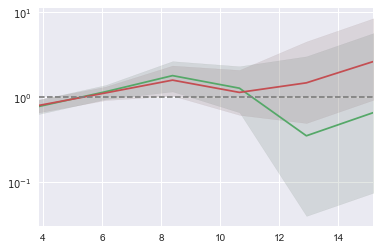

In [283]:
plot_bin_susties(data=words[words.property == 'aoa'], quantiles=False, binning=6)

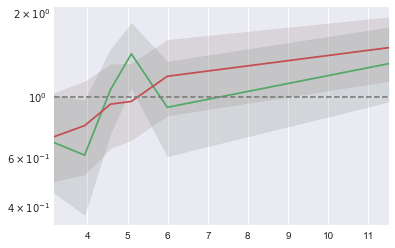

In [284]:
plot_bin_susties(data=words[words.property == 'aoa'], quantiles=True, binning=6)

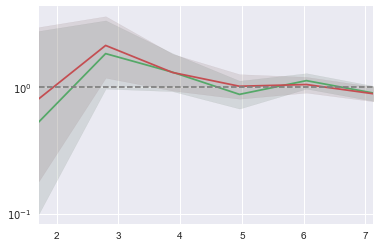

In [286]:
plot_bin_susties(data=words[words.property == 'zipf_frequency'], quantiles=False, binning=6)

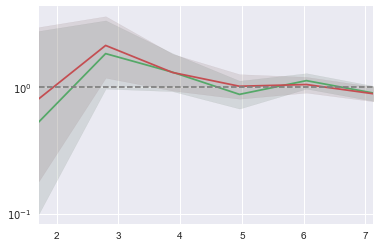

In [294]:
plot_bin_susties(data=words[words.property == 'zipf_frequency'], quantiles=False, binning=6)

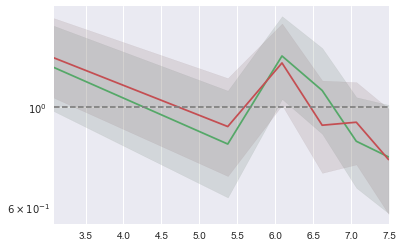

In [293]:
plot_bin_susties(data=words[words.property == 'zipf_frequency'], quantiles=True, binning=6)

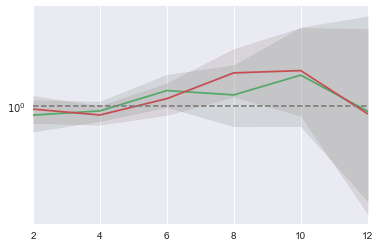

In [295]:
plot_bin_susties(data=words[words.property == 'letters_count'], quantiles=False, binning=6)

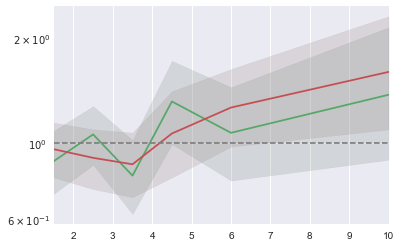

In [296]:
plot_bin_susties(data=words[words.property == 'letters_count'], quantiles=True, binning=6)

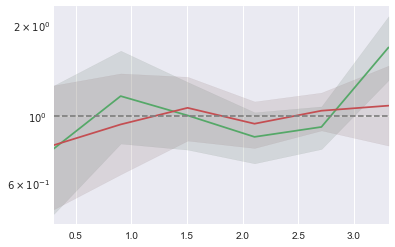

In [299]:
plot_bin_susties(data=words[words.property == 'orthographic_density'],
                 quantiles=False, binning=6)

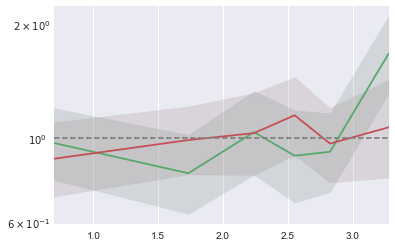

In [300]:
plot_bin_susties(data=words[words.property == 'orthographic_density'],
                 quantiles=True, binning=6)